# Уравнение Кортевега-де-Фриза

## Теоретическая часть

### Построение солитонного решения

Уравнение имеет следующий вид:

$$\dfrac{\partial u}{\partial t} + 6u \dfrac{\partial u}{\partial x} + \dfrac{\partial^3 u}{\partial x^3} = 0$$

Уравнение автономно, следовательно допускает решение в виде волны, распростроняющейся со скоростью $V: u = \omega(x - Vt)$. Подставляя это в уравнение, находим

$$-V\dfrac{\partial \omega}{\partial x} + 6\omega \dfrac{\partial \omega}{\partial x} + \dfrac{\partial^3 \omega}{\partial x^3} = 0.$$

Это уравнение имеет первый интеграл

$$-V \omega + 3\omega^2 + \dfrac{\partial^2 \omega}{\partial x^2} = C.$$

Получившееся соотношение имеет вид уравнения Ньютона для "времени" $x$ и "координаты" $\omega$ с потенциальной силой. Поэтому оно имеет первый интеграл ("энергию" $E$), то есть

$$\left(\dfrac{d \omega}{d x}\right)^2 = 2E + 2C \omega + V \omega^2 - 2 \omega^3$$,

где $E$ и $C$ – произвольные константы.

Мы интересуемся солитонными решениями, то есть локализованными, следовательно нужно положить $E=C=0$, поскольку только при таких условиях существует решение, стремящееся к нулю при $x \rightarrow \pm \infty$. Тогда мы находим 

$$\dfrac{d\omega}{dx} = \pm \sqrt{V - 2\omega}.$$

Это уравнение имеет решение

$$u(t, x) = \dfrac{V}{2 \cosh^2\left(\sqrt{V}(x - Vt - x_0)/2\right)},$$

где $x_0$ – произвольный параметр. Таким образом, ширина солитона, который движется со скоростью $V$, равна $1/\sqrt{V}$.

### Концепция алгоритма

Мы получили солитонное решение уравнения Кортевега-де-Фриза. Назовем его $u_s(x, t, V, x_0)$, отразив зависимость от произвольных параметров скорости $V$ и сдвига $x_0$. Теперь нам нужно промоделлировать динамику нескольких солитонов. Будем решать это уравнение на отрезке $[-\pi, \pi]$, ширина отрезка равна $L = 2\pi$. Исходя из того, что солитоны локализованы, можно считать, что взяв граничные условия в момент времени $t=0$ в виде

$$u(x, 0) = \sum_{i=1}^n u_s(x, 0, V^i, x_0^i),$$

мы получим в приближенно суперпозицию $n$ невзаимодействующих солитонов. Чтобы это было действительно так, они должны быть достаточно сильно удалены друг от друга, то есть $\forall i \neq j$  $|x_0^i - x_0^j| \simeq 1/\sqrt{V}$. Это самое простое приближение, но мы будем работать именно с ним. 

Теперь о способе численного решения уравнение Кортевега-де-Фриза. Для начала вводится сетка для дискретизации. Выбирается количество "шагов" сетки $N$, тогда шаг сетки равен $h = L/N = 2\pi /N$. Решать уравнение будем методом Фурье, перепишем его в следующем виде

$$ \dfrac{\partial u}{\partial t} = - 3 \dfrac{\partial u^2}{\partial x} - \dfrac{\partial^3 u}{\partial x^3}.$$

Сделаем прямое дискретное преобразование Фурье от обеих частей, чтобы избавиться от производных по координате:

$$\hat{u} = - 3ik \widehat{\check{\hat{u}}^2} - ik^3 \hat{u}.$$

Здесь $k$ пробегает числа от $-N/2$ до $N/2$ с шагом в единицу. Мы получили обыкновенную систему дифференциальных уравнений ($\hat{u}$ в некоторый момент $t$ – $N$- мерный вектор), которую будем решать классическим методом Рунге-Кутты четвертого порядка. После этого возвращаемся к реальной задаче обратным преобразованием Фурье.

## Программная реализация алгоритма

Будем моделировать динамику четырех солитонов. Импортируем необходимые библиотеки. Для прямого и обратного преобразования Фурье использовались готовые функции библиотеки SciPy, остальное – для рисования.

In [94]:
import numpy as np
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

Стандартная реализация метода Рунге-Кутты четвертого порядка. $k_1, k_2, k_3, k_4$ – соответственно, четыре стадии корректировки решения. step – величина шага сетки уже по времени.

In [95]:
def rungeKutta(f, u0, t0, t_max, n):
    
    u_hat = np.empty((n, u0.size), dtype=complex)
    u_hat[0] = u0_hat
    t = np.linspace(t0, t_max, n)
    step = (t_max - t0) / (n - 1)
    
    for i in np.arange(0, n - 1):
        
        k1 = f(u_hat[i], t[i])
        k2 = f(u_hat[i] + 0.5 * step * k1, (t[i+1] + t[i]) * 0.5)
        k3 = f(u_hat[i] + 0.5 * step * k2, (t[i+1] + t[i]) * 0.5)
        k4 = f(u_hat[i] + step * k3, t[i+1])
        
        u_hat[i+1] = u_hat[i] + (step / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    
    return u_hat

Инициализация гранично-нулевых условий; количество шагов координатной сетки; сама дискретная сетка; временной домен для решения задачи и временная сетка для метода Рунге-Кутты; выбор свободных параметров в солитонном аналитическом решении Кортевега-де-Фриза. Инициализация $k$ – волновых чисел, возникающих при прямом дискретном преобразовании Фурье. scipy.fftpack.fft любит симметричный спектр, поэтому волновые числа в массиве симметричны относительно нуля. Также введение функции, задающей правую часть системы дифференциальных уравнений в Фурье-пространстве.

In [96]:
N_steps = 300
x = (2.0*np.pi / N_steps) * np.arange(-N_steps / 2, N_steps / 2).reshape(N_steps, 1)
max_t = 0.01
dt = max_t / N_steps**2
t_steps = int(max_t / dt)

V  = np.array([23.5**2, 11**2, 18**2, 9**2])
x0 = [3.0, -2, 2.0, 0.3]

u0 = 0
for i in range(V.size):
    u0 += (0.5 * V[i] * np.cosh(0.5 * (np.sqrt(V[i]) * (x + x0[i])))**(-2.)).reshape(N_steps,)

k_plus = np.arange(0, N_steps / 2)
k_mins = np.arange(-N_steps / 2 + 1, 0, 1)
k = np.concatenate((k_plus, np.array([0]), k_mins)).reshape(N_steps, )

def fourier_eq(u_hat, t):
    return -3.0 * 1j * k * fft(ifft(u_hat, axis=0)**2.0, axis=0)  + 1j * k**3.0 * u_hat

Решение системы дифференциальных уравнений в Фурье-пространстве.

In [97]:
u0_hat = fft(u0, axis=0)
u_hat = rungeKutta(fourier_eq, u0, t0=0, t_max=max_t, n=t_steps)

Обратное преобразование Фурье, графическая часть задачи. Выбираем, насколько "гладкой" будет наша картинка. За это отвечает параметр data_smooth. Проходимся по временному домену, делаем обратное преобразование Фурье в соответствующей точке, добавляем в массив $u$ новый столбец. Чтобы избежать неприятных выбросов и дополнительно сгладить данные, в случае появления в массиве неопределенного числа заменяем его соответственно на 0 или на очень большое число (np.nan_to_num). Из временной сетки тоже нужно сделать массив, чтобы затем сделать двумерную сетку для отрисовки поверхности, натянутой на поле $u(x, t)$.

In [98]:
u, t = np.real(ifft(u0_hat, axis=0)).reshape(N_steps, 1), np.array(0).reshape(1, 1)

data_smooth = int(np.floor((max_t/50.)/dt))

for n in range(1, t_steps):
    if n % data_slice == 0:
        t_i = n * dt
        u_real = np.real(ifft(u_hat[n], axis=0)).reshape(N_steps, 1)
        u = np.concatenate((u,np.nan_to_num(u_real)), axis=1)
        t = np.concatenate((t, np.array(t_i).reshape(1, 1)), axis=1)
        
t, x = np.meshgrid(t, x, indexing='ij')

Далее, окончательно, визуализация динамики четырех солитонов.

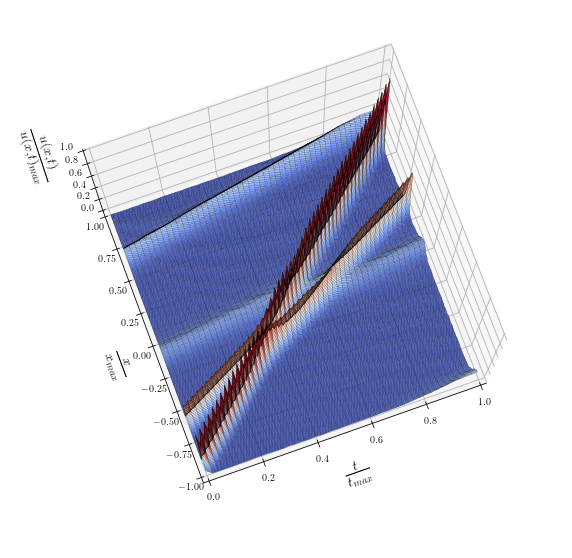

In [109]:
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
        
fig = plt.figure(figsize=[10, 10])

ax = fig.gca(projection='3d')
ax.view_init(elev=80., azim=250)
ax.plot_surface(t/max_t, x/np.pi, u.T / np.max(u.T), rstride=1, cstride=1, cmap='coolwarm',
                         linewidth=0)
ax.plot_wireframe(t/max_t, x/np.pi, u.T / np.max(u.T), color='black', rstride=1, cstride=1, 
                         linewidth=0.2)
ax.invert_yaxis()
ax.set_xlim(0, 1)
ax.set_ylim(-1, 1);
ax.set_zlim(0., 1)
ax.set_xlabel(r'$\frac{t}{t_{max}}$', size=20, labelpad=20); 
ax.set_ylabel(r'$\frac{x}{x_{max}}$', size=20, labelpad=20); 
ax.set_zlabel(r'$\frac{u(x, t)}{u(x, t)_{max}}$', size=20, labelpad=20)

plt.show()